# Domain Adaptation Playground

Heavily modified from ch7_nb5_train_a_simple_domain_adversarial_network_(dann)
https://github.com/ilmechaJu/dl-vision/blob/master/Chapter07/ch7_nb5_train_a_simple_domain_adversarial_network_(dann).ipynb

### Imports

In [1]:
# Needeed library and imports

import numpy as np



from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

from da_playground_tools_tfdataset import create_sample_blobs,  plot_3d_source_and_target_blobs
from da_playground_tools_tfdataset import AdditionalValidationSets

from functools import partial

### Set random seeds

In [2]:

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### Problem parameters

In [3]:
num_classes = 2
input_size  = (3,)
num_epochs  = 100
batch_size  = 100

## Dataset

### Dataset factory

In [4]:
help(create_sample_blobs)

Help on function create_sample_blobs in module da_playground_tools_tfdataset:

create_sample_blobs(blob_centers, blob_stds, blob_num_samples, shuffle=True)
    Create X blobs of N_x elements of shape (D_0, ..., D_d), picked from different 
    normal distributions N(m_x, s_x).
    Note: this is a simplified version of the method `sklearn.datasets.make_blobs`
    :param blob_centers:     Array of shape (X, D_0, ..., D_d) defining the distribution means m_x
    :param blob_stds:        Array of shape (X, D_0, ..., D_d) defining the distribution STDs s_x
    :param blob_num_samples: Array of shape (X,) defining the numbers N_x of elements per blob
    :param shuffle:          Flag to shuffle the elements from all blobs
    :return:                 x: Samples array of shape (N_0 + ... + N_x, D_0, ..., D_d) 
                             y: Class array of shape (N_0 + ... + N_x,)



### Source Domain

Let's throw some points in 3D that will be our source domain

In [5]:
num_source_samples_per_class = 500
num_source_samples = num_source_samples_per_class * num_classes * 3 #Train, Valid, Test

x_source, y_source = create_sample_blobs(
    blob_centers=[[0, 0, 0],  # center of blob for class 0
                  [2, 4, 4]], # center of blob for class 1
    blob_stds=[[.5, .5, .5],  # STD of blob for class 0
               [.5, .5, .5]], # STD of blob for class 01
    blob_num_samples=[num_source_samples_per_class * 3] * num_classes)


x_source_train, x_source_valid_test, y_source_train, y_source_valid_test = \
    train_test_split(x_source, y_source,
        train_size = num_source_samples_per_class * num_classes,
        shuffle = True, stratify = y_source)

x_source_valid, x_source_test, y_source_valid, y_source_test = \
    train_test_split(x_source_valid_test, y_source_valid_test,
        train_size = num_source_samples_per_class * num_classes,
        shuffle = True, stratify = y_source_valid_test)

del x_source, y_source, x_source_valid_test, y_source_valid_test



We can plot the dataset in 3D with the help of the `plot_3d_source_and_target_blobs` function

/Users/rherault/Travail/UCN/Enseignement/Automne/APA/tex/CM/CM03-DomainAdaptation/notebook/da_playground_tools_tfdataset.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


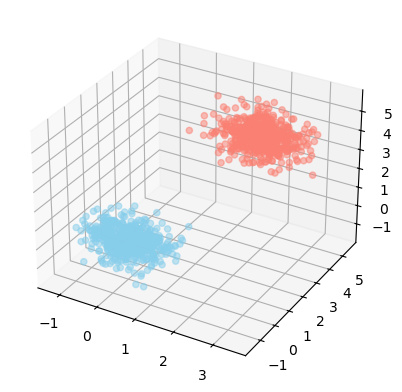

In [6]:
plot_3d_source_and_target_blobs(x_source_train, y_source_train)

### Target domain
Let's now throw some points in 3D that will be our target domain

In [7]:
num_target_samples_per_class = 200
num_target_samples = num_target_samples_per_class * num_classes * 3 #Train, Valid, Test

x_target, y_target = create_sample_blobs(
    blob_centers=[[6, 3, 3], [7, 6, 7]], 
    blob_stds=[[1, 1, 1], [1, 1, 1]], 
    blob_num_samples= [num_target_samples_per_class * 3] * num_classes)

x_target_train, x_target_valid_test, y_target_train, y_target_valid_test = \
    train_test_split(x_target, y_target,
        train_size = num_target_samples_per_class * num_classes,
        shuffle = True, stratify = y_target)

x_target_valid, x_target_test, y_target_valid, y_target_test = \
    train_test_split(x_target_valid_test, y_target_valid_test,
        train_size = num_target_samples_per_class * num_classes,
        shuffle = True, stratify = y_target_valid_test)

del x_target, y_target, x_target_valid_test, y_target_valid_test


Let's plot them

/Users/rherault/Travail/UCN/Enseignement/Automne/APA/tex/CM/CM03-DomainAdaptation/notebook/da_playground_tools_tfdataset.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


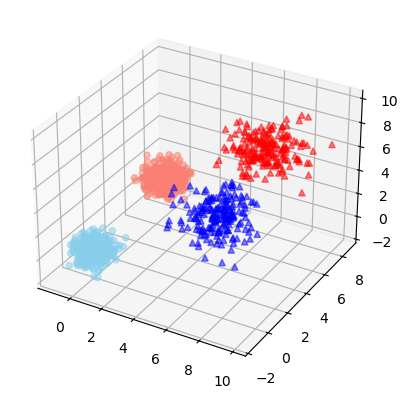

In [8]:
plot_3d_source_and_target_blobs(x_source_train, y_source_train, x_target_train, y_target_train)

## Domain adaptation setup

We want to build a Classifer on the target domain without knowing their label

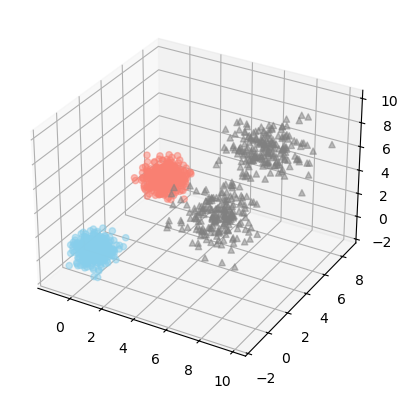

In [9]:
plot_3d_source_and_target_blobs(x_source_train, y_source_train, x_target_train)

## Naive approach

We will use a naïve approach by only training on the source domain


### Label classification model and training on the source domain 

In [10]:
# Name of the final layer of our simple classifier:
label_preds_head_name = 'label_preds' 

inputs        = Input(shape=input_size)
hidden1       = Dense(5, activation='tanh')(inputs)
hidden2       = Dense(10, activation='tanh')(hidden1)
label_preds   = Dense(num_classes, activation='softmax', name=label_preds_head_name)(hidden2)  

naive_label_model = Model(inputs=inputs, outputs=label_preds, name="NaiveLabelModel")
naive_label_model.summary()

Model: "NaiveLabelModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 label_preds (Dense)         (None, 2)                 22        
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


### How to follow additional validation set (i.e. the domain validation set)

In [11]:
help(AdditionalValidationSets)

Help on class AdditionalValidationSets in module da_playground_tools_tfdataset:

class AdditionalValidationSets(keras.callbacks.Callback)
 |  AdditionalValidationSets(validation_sets, verbose=0, updatelogs=1, batch_size=None)
 |  
 |  Method resolution order:
 |      AdditionalValidationSets
 |      keras.callbacks.Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, validation_sets, verbose=0, updatelogs=1, batch_size=None)
 |      :param validation_sets:
 |      a list of 3-tuples (validation_data, validation_targets, validation_set_name)
 |      or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
 |      :param verbose:
 |      verbosity mode, 1 or 0
 |      :param batch_size:
 |      batch size to be used when evaluating on the additional datasets
 |  
 |  on_epoch_end(self, epoch, logs=None)
 |      Called at the end of an epoch.
 |      
 |      Subclasses should override for any actions to run. This function s

### Training

In [12]:
naive_label_model.compile(optimizer="adam",
                             loss='sparse_categorical_crossentropy', 
                             metrics=[tf.metrics.SparseCategoricalAccuracy(name='acc')])

extravalset_callback = AdditionalValidationSets([(x_target_valid, y_target_valid, 'target_valid')])

history = naive_label_model.fit(
    x_source_train, y_source_train, batch_size=batch_size, epochs=num_epochs, 
    validation_data=(x_source_valid, y_source_valid), 
    verbose=1, callbacks=[extravalset_callback])

Epoch 1/100


2023-09-19 15:41:34.099271: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 1s 34ms/step - loss: 0.4870 - acc: 0.7570 - val_loss: 0.4618 - val_acc: 0.7670 - target_valid_loss: 0.8525 - target_valid_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 0s 16ms/step - loss: 0.4449 - acc: 0.7850 - val_loss: 0.4221 - val_acc: 0.8000 - target_valid_loss: 0.8216 - target_valid_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.4080 - acc: 0.8020 - val_loss: 0.3873 - val_acc: 0.8240 - target_valid_loss: 0.7966 - target_valid_acc: 0.5000
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 0.3751 - acc: 0.8310 - val_loss: 0.3556 - val_acc: 0.8490 - target_valid_loss: 0.7799 - target_valid_acc: 0.5000
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 0.3452 - acc: 0.8610 - val_loss: 0.3264 - val_acc: 0.8780 - target_valid_loss: 0.7664 - target_valid_acc: 0.5000
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 0.3

### Model evaluation

In [13]:
print("Measuring classification accuracy on source/test data:")
res = naive_label_model.evaluate(x_source_test, y_source_test)
print("\nMeasuring classification accuracy on target/test data:")
res = naive_label_model.evaluate(x_target_test, y_target_test)

Measuring classification accuracy on source/test data:
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - acc: 1.0000

Measuring classification accuracy on target/test data:
13/13 [==============================] - 0s 4ms/step - loss: 1.2983 - acc: 0.5000


13/13 [==============================] - 0s 2ms/step


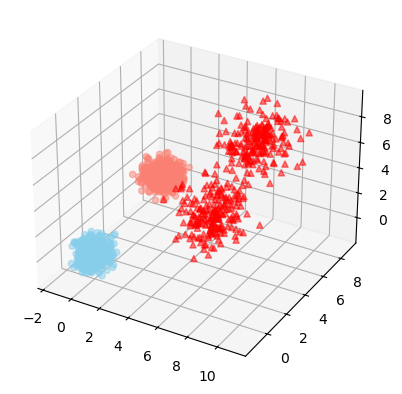

In [14]:
y_source_test_pred = naive_label_model.predict(x_source_test).argmax(1)
y_target_test_pred = naive_label_model.predict(x_target_test).argmax(1)

plot_3d_source_and_target_blobs(x_source_test, y_source_test_pred, x_target_test, y_target_test_pred)

## Domain adaptation approach using Gradient Reversal Layer

### GRL implementation in keras/tensorflow

In [15]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:         Input tensor
    :param hp_lambda: Hyper-parameter lambda (c.f. DANN paper), i.e. an updatable 
                      coefficient applied to the reversed gradient
    :return:          Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """
    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient

In [16]:
class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Label class and Domain classification models combined into one model

We construct our network using the functional API in order to enable to possible outputs one for label classification, the other one for domain classification

In [17]:
# Common layers
inputs        = Input(shape=input_size) 
hidden1       = Dense(5, activation='tanh')(inputs)
hidden2       = Dense(10, activation='tanh')(hidden1)


# ==> Specific layers for label classficiation

# Name of the final layer of our simple classifier:
label_preds_head_name = 'label_preds' 

label_preds = Dense(num_classes, activation='softmax', name=label_preds_head_name)(hidden2)  

# ==> Specific layers for domain classficiation

# We create another simple classification sub-network:
domain_preds_head_name = 'domain_preds'

hp_lambda = tf.Variable(1.0)
num_domains = 2 # "source" vs. "target"

x = GradientReversal(hp_lambda)(hidden2)
domain_preds = Dense(num_domains, activation='softmax', name=domain_preds_head_name)(x)




Here is the classification model for the labels only

In [18]:
label_model = Model(inputs=inputs, outputs=label_preds, name="LabelModel")
label_model.summary()

label_model.compile(optimizer="adam",
                             loss='sparse_categorical_crossentropy', 
                             metrics=[tf.metrics.SparseCategoricalAccuracy(name='acc')])

Model: "LabelModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
 label_preds (Dense)         (None, 2)                 22        
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________


Here is the classification model for the domains only

In [19]:
domain_model = Model(inputs=inputs, outputs=domain_preds, name="DomainModel")
domain_model.summary()
domain_model.compile(optimizer="adam",
                             loss='sparse_categorical_crossentropy', 
                             metrics=[tf.metrics.SparseCategoricalAccuracy(name='acc')])

Model: "DomainModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
 gradient_reversal (Gradient  (None, 10)               1         
 Reversal)                                                       
                                                                 
 domain_preds (Dense)        (None, 2)                 22        
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________

And now we setup the combined model

In [20]:
combined_model = Model(inputs=inputs, outputs=[label_preds, domain_preds], name="CombinedModel")

combined_model.compile(
    optimizer="adam",
    loss={
        label_preds_head_name:  'sparse_categorical_crossentropy',
        domain_preds_head_name: 'sparse_categorical_crossentropy'},
    loss_weights={
        label_preds_head_name:  1, 
        domain_preds_head_name: 1},
    weighted_metrics={
        label_preds_head_name:  tf.metrics.SparseCategoricalAccuracy(name='acc'),
        domain_preds_head_name: tf.metrics.SparseCategoricalAccuracy(name='acc')},
)

combined_model.summary()

Model: "CombinedModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 5)            20          ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 10)           60          ['dense_2[0][0]']                
                                                                                                  
 gradient_reversal (GradientRev  (None, 10)          1           ['dense_3[0][0]']                
 ersal)                                                                               

The dataset needs to be prepare with weights sets for each loss.

In [21]:
def generator(dataset, out_1_name, out_2_name):
    x, yy, sw= dataset
    for i in range(x.shape[0]):
        yield x[i:i+1], \
            {out_1_name:yy[out_1_name][i:i+1], out_2_name:yy[out_2_name][i:i+1]}, \
            {out_1_name:sw[out_1_name][i:i+1], out_2_name:sw[out_2_name][i:i+1]}

def convdataset2tf(dataset,out_1_name,out_2_name):
    return tf.data.Dataset.from_generator(
                    partial(generator,dataset,out_1_name,out_2_name),
                    output_types=(tf.float64,
                        {out_1_name: tf.int32, out_2_name: tf.int32},
                        {out_1_name: tf.int32, out_2_name: tf.int32}),
                    output_shapes=([None,3],
                        {out_1_name: [None,], out_2_name: [None,]},
                        {out_1_name: [None,], out_2_name: [None,]})
                    )


In [22]:
# dataset = X,Y, Sample Weight
# X = X
# Y = {label_preds_head_name: Y Label, domain_preds_head_name: Y Domain }
# Sample Weight= {label_preds_head_name: label loss weight, domain_preds_head_name: domain loss weight }

# Source train: loss/metrics on label and domain
sw_source_train = {
    label_preds_head_name: np.ones((y_source_train.shape[0],),dtype='int32'),
    domain_preds_head_name: np.ones((y_source_train.shape[0],),dtype='int32')}
domain_source_train = np.ones((y_source_train.shape[0],),dtype='int32')
yy_source_train = {
    label_preds_head_name: y_source_train,
    domain_preds_head_name: domain_source_train}
source_train = x_source_train, yy_source_train, sw_source_train
tf_source_train = convdataset2tf(source_train, label_preds_head_name, domain_preds_head_name)


# Source valid: metrics on label and domain
sw_source_valid = {
    label_preds_head_name: np.ones((y_source_valid.shape[0],),dtype='int32'),
    domain_preds_head_name: np.ones((y_source_valid.shape[0],),dtype='int32')}
domain_source_valid = np.ones((y_source_valid.shape[0],),dtype='int32')
yy_source_valid = {
    label_preds_head_name: y_source_valid,
    domain_preds_head_name: domain_source_valid}
source_valid = x_source_valid, yy_source_valid, sw_source_valid
tf_source_valid = convdataset2tf(source_valid, label_preds_head_name, domain_preds_head_name)

# Target train: loss/metrics on domain only 
sw_target_train = {
    label_preds_head_name: np.zeros((y_target_train.shape[0],),dtype='int32'),
    domain_preds_head_name: np.ones((y_target_train.shape[0],),dtype='int32')}
domain_target_train = np.zeros((y_target_train.shape[0],),dtype='int32')
yy_target_train = {
    label_preds_head_name: y_target_train,
    domain_preds_head_name: domain_target_train}
target_train = x_target_train, yy_target_train, sw_target_train
tf_target_train = convdataset2tf(target_train, label_preds_head_name, domain_preds_head_name)

# Target valid: metrics on label and domain
sw_target_valid = {
    label_preds_head_name: np.ones((y_target_valid.shape[0],),dtype='int32'),
    domain_preds_head_name: np.ones((y_target_valid.shape[0],),dtype='int32')}
domain_target_valid = np.zeros((y_target_valid.shape[0],),dtype='int32')
yy_target_valid = {
    label_preds_head_name: y_target_valid,
    domain_preds_head_name: domain_target_valid}
target_valid = x_target_valid, yy_target_valid, sw_target_valid
tf_target_valid = convdataset2tf(target_valid, label_preds_head_name, domain_preds_head_name)




We prepare a train dataset consisting in source labeled and target unlabeled, as well as a validation dataset with both domains

In [23]:
# tf_dataset_train = tf_source_train + tf_target_train

tf_dataset_train_nc = tf_source_train.concatenate(tf_target_train)
tf_dataset_train = tf_dataset_train_nc.shuffle(buffer_size= batch_size).batch(batch_size)

# tf_dataset_valid = tf_source_valid + tf_target_valid

tf_dataset_valid_nc = tf_source_valid.concatenate(tf_target_valid)
tf_dataset_valid = tf_dataset_valid_nc.batch(batch_size)

We train...

In [24]:
extravalset_callback = AdditionalValidationSets([(tf_target_valid.batch(batch_size) , 'target_valid')])

history = combined_model.fit(
    tf_dataset_train,
    epochs=num_epochs, 
    validation_data=tf_dataset_valid,
    callbacks=[extravalset_callback]
)



Epoch 1/100
14/14 [==============================] - 2s 72ms/step - loss: 1.1932 - label_preds_loss: 0.4620 - domain_preds_loss: 0.7312 - label_preds_acc: 0.7290 - domain_preds_acc: 0.4443 - val_loss: 1.3564 - val_label_preds_loss: 0.6275 - val_domain_preds_loss: 0.7288 - val_label_preds_acc: 0.6836 - val_domain_preds_acc: 0.4500 - target_valid_loss: 1.2625 - target_valid_label_preds_loss: 0.7087 - target_valid_domain_preds_loss: 0.5538 - target_valid_label_preds_acc: 0.5000 - target_valid_domain_preds_acc: 0.9975
Epoch 2/100
14/14 [==============================] - 0s 32ms/step - loss: 1.1482 - label_preds_loss: 0.4160 - domain_preds_loss: 0.7322 - label_preds_acc: 0.7450 - domain_preds_acc: 0.4336 - val_loss: 1.3276 - val_label_preds_loss: 0.5962 - val_domain_preds_loss: 0.7315 - val_label_preds_acc: 0.6914 - val_domain_preds_acc: 0.4414 - target_valid_loss: 1.2818 - target_valid_label_preds_loss: 0.7301 - target_valid_domain_preds_loss: 0.5518 - target_valid_label_preds_acc: 0.5000 

Model evaluation

In [25]:
print("Measuring classification accuracy on source/test data:")
res = label_model.evaluate(x_source_test, y_source_test)
print("\nMeasuring classification accuracy on target/test data:")
res = label_model.evaluate(x_target_test, y_target_test)

Measuring classification accuracy on source/test data:
32/32 [==============================] - 0s 5ms/step - loss: 0.0073 - acc: 1.0000

Measuring classification accuracy on target/test data:
13/13 [==============================] - 0s 6ms/step - loss: 0.2045 - acc: 0.9100


We can also once again visualize the predicted labels:

13/13 [==============================] - 0s 2ms/step


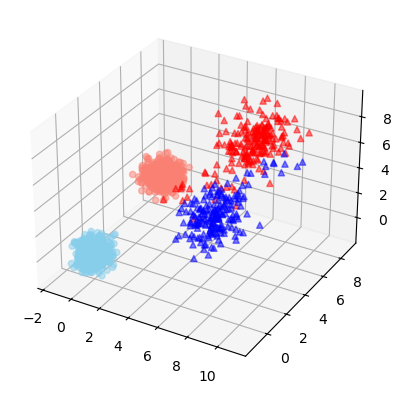

In [26]:
y_source_test_pred = label_model.predict(x_source_test).argmax(1)
y_target_test_pred = label_model.predict(x_target_test).argmax(1)

plot_3d_source_and_target_blobs(x_source_test, y_source_test_pred, x_target_test, y_target_test_pred)